In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.image as img
import math

%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
df = pd.read_csv('/content/drive/My Drive/temp_image_1.csv')
review = pd.read_csv('/content/drive/My Drive/temp_review_1.csv')
df.drop('Unnamed: 0', inplace= True, axis = 1)
review.drop('Unnamed: 0', inplace= True, axis = 1)

In [3]:
image_usage = pd.read_csv('/content/drive/My Drive/Final/category_engg_data_usage.csv')
image_usage.drop('usage', axis = 1, inplace = True)
image_article = pd.read_csv('/content/drive/My Drive/Final/category_data_initial.csv')
image_article.drop('articleType', inplace = True, axis = 1)
image_gender = pd.read_csv('/content/drive/My Drive/Final/feature_engg_data_gender.csv')
image_season = pd.read_csv('/content/drive/My Drive/Final/feature_engg_data_season.csv')

**User-Rating Matrix (Pivot Table)**

In [4]:
table = review.pivot_table(columns = 'asin', index = 'reviewerID', values = 'overall')

**Scaled Item - Item correlation csv file**

In [ ]:
item_corr = pd.read_csv('/content/drive/My Drive/Final/ITEM_ITEM.csv')
item_corr.set_index('asin', inplace=True)

**Item-Item Correlation csv without Scaled**

In [5]:
item_original = pd.read_csv('/content/drive/My Drive/Final/Item_orginal.csv')
item_original.set_index('asin', inplace = True)

**Scale user - rating matrix if required**

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler() 
mean_table = scaler.fit_transform(table)
table = pd.DataFrame(index = table.index, columns = table.columns, data = mean_table)

**Pearson Correlation on Image Categorical Features**

In [6]:
image_season.set_index('image_Names', inplace=True)
season_corr = image_season.transpose().corr()
image_article.set_index('image_Names', inplace=True)
article_corr = image_article.transpose().corr()
image_usage.set_index('image_Names', inplace=True)
usage_corr = image_usage.transpose().corr()
image_gender.set_index('image_Names', inplace=True)
gender_corr = image_gender.transpose().corr()

**Unzip Image File**

In [ ]:
!unzip '/content/drive/My Drive/Final Clothing_5core.zip'
os.chdir('/content/Final Clothing_5core')

**Function to Rate similar images based on item-item Similarity**

In [8]:
def rating_cal(user, similar_images):
  rating_dict = dict((x,0) for x in similar_images)
  user_images = list(review[review['reviewerID'] == user]['asin'])
  temp = similar_images
  similar_images = []
  for i in temp:
    similar_images.append(i.split('.')[0])

  for i in similar_images:   #Calculating Rating Based on Item Item 
    rating = 0
    deno = 0
    num = 0
    for j in user_images:
      sim_i_j = item_original.loc[i, j]
      user_rating_j = table.loc[user, j]
      deno = deno + sim_i_j
      num = num + sim_i_j * user_rating_j
    rating = num/deno      
    if rating<0:
      rating = 1
    if rating>5:
      rating = 5
    rating_dict[i] = rating
  rating_dict = sorted(rating_dict.items(), key=lambda x: x[1], reverse =  True)
  
  return rating_dict, user_images

**Function to select top ten similar images based on season, style, article type and gender**

In [53]:
  main_image = 'B01B48O3U4.jpg'
  similar_images = []
  x = 10
  temp = season_corr.loc[main_image].sort_values(ascending = False).head(x).index
  for i in temp:
    if i != main_image:
      if i not in similar_images:
        similar_images.append(i)
  
      
  temp = article_corr.loc[main_image].sort_values(ascending = False).head(x).index
  for i in temp:
    if i != main_image:
      if i not in similar_images:
        similar_images.append(i)

  temp = gender_corr.loc[main_image].sort_values(ascending = False).head(x).index
  for i in temp:
    if i != main_image:
      if i not in similar_images:
        similar_images.append(i)

  temp = usage_corr.loc[main_image].sort_values(ascending = False).head(x).index
  for i in temp:
    if i != main_image:
      if i not in similar_images:
        similar_images.append(i)
  similar_images = list(set(similar_images))


**Call function to find and similar images and rate the images**

In [55]:
user = 'A2OCDK0BOW6UCY'
rating_dict, user_images = rating_cal(user, similar_images)
rating_dict = dict(rating_dict)
rating_dict = sorted(rating_dict.items(), key=lambda x: x[1], reverse =  True)
final_images = [i[0] for i in rating_dict]
temp = final_images
final_images = []
for i in temp:
  final_images.append(i + '.jpg')
temp = user_images
user_images = []
for i in temp:
  user_images.append(i + '.jpg')

**Print Image on Which user clicked**

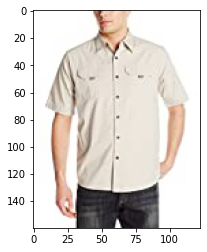

In [56]:
im = img.imread(main_image) 
imgplot = plt.imshow(im)

**Display Users Images**

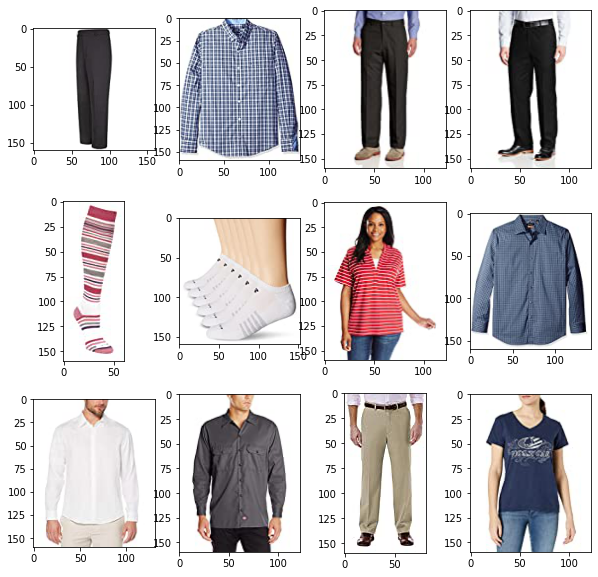

In [58]:
x = 3
y = 4
f, axarr = plt.subplots(x,y, figsize = (10,10))
index = 0
for i in range(x):
    for j in range(y):
        im = img.imread(user_images[index]) 
        axarr[i,j].imshow(im)
        index = index +1

**Recommended Images**

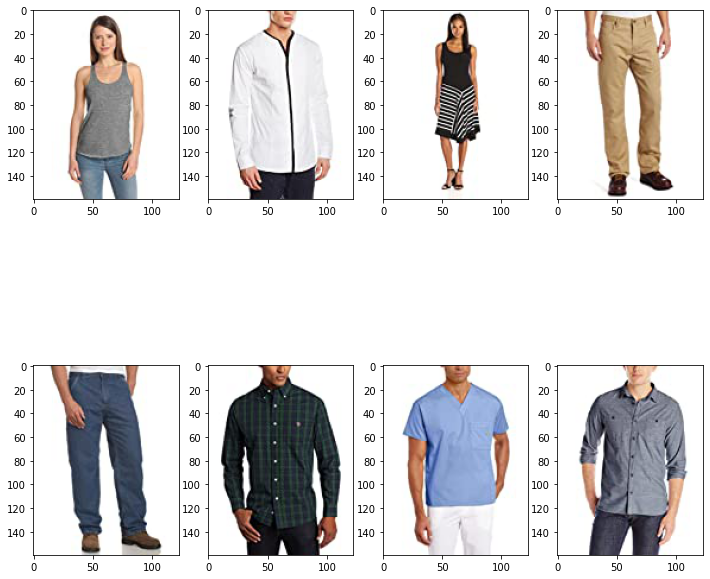

In [61]:
x = 2
y = 4
f, axarr = plt.subplots(x,y, figsize = (12,12))
index = 1
for i in range(x):
    for j in range(y):
        im = img.imread(final_images[index]) 
        axarr[i,j].imshow(im)
        index = index +1

**Testing accuracy**

In [ ]:
count_user = review.groupby('reviewerID').count()
count_user.reset_index(drop = False, inplace = True)
# Global scope 
train_df = pd.DataFrame(columns=['reviewerID', 'asin', 'overall'])
test_df = pd.DataFrame(columns = ['reviewerID', 'asin', 'overall'])
review = review.sample(frac=1).reset_index(drop=True)   # Shuffling the data

**Function To split into train and test**

In [ ]:
def split(user):
  noOfReview = int(count_user[count_user['reviewerID'] == user]['overall'])
  user_images = list(review[review['reviewerID'] == user]['asin'])
  train = int(round(noOfReview/4*3))
  train_list = user_images[:train]
  test_list = user_images[train:]
  global train_df
  global test_df
  for i in train_list:
    train_df = train_df.append({'reviewerID': user, 'asin': i, 'overall': table.loc[user, i]}, ignore_index=True)
  for i in test_list:
    test_df = test_df.append({'reviewerID': user, 'asin': i, 'overall': table.loc[user, i]}, ignore_index=True)
  


In [ ]:
for i in review.reviewerID.unique():
  split(i)

**Calculating the rating (Similar function as above)**

In [ ]:
def rating_cal(user, similar_images):
  rating_dict = dict((x,0) for x in similar_images)
  user_images = list(train_df[train_df['reviewerID'] == user]['asin'])
  temp = similar_images
  similar_images = []
  for i in temp:
    similar_images.append(i.split('.')[0])

  for i in similar_images:
    rating = 0
    deno = 0
    num = 0
    for j in user_images:
      sim_i_j = item_orginal.loc[i, j]
      user_rating_j = table.loc[user, j]
      deno = deno + sim_i_j
      num = num + sim_i_j * user_rating_j
    rating = num/deno
    if rating<0:
      rating = 1
    if rating>5:
      rating = 5
    rating_dict[i] = rating
  rating_dict = sorted(rating_dict.items(), key=lambda x: x[1], reverse =  True)
  
  return rating_dict

**Chaning Index and droping similar Rows**

In [ ]:
test_df.reset_index(inplace = True, drop = True)
test_df.drop_duplicates(keep = 'first', inplace = True)
test_df['predicted'] = np.nan
test_df.set_index(['reviewerID', 'asin'], inplace = True)
temp = test_df.reset_index()

In [ ]:
for i in temp.reviewerID.unique():
   similar_images = list(temp[temp['reviewerID'] == i]['asin'])
   ratings = rating_cal(i, similar_images)
   for j in ratings: 
     image = j[0]
     test_df.loc[(i, image)].replace(np.nan, j[1], inplace = True)
   

**Calculating RMSE and MSE**

In [ ]:
from sklearn.metrics import mean_squared_error
y = test_df['overall']
y_pred = test_df['predicted']
mse = mean_squared_error(y, y_pred)
from math import sqrt
rmse = sqrt(mean_squared_error(y, y_pred))
print('MSE = ' + str(mse))
print('RMSE = ' + str(rmse))
